<h1>Sieci neuronowe - ćwiczenie 5</h1>

In [1]:
!pip install torch torchvision

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassF1Score, MulticlassRecall

In [3]:
torch.cuda.is_available() # check if torch is available to use GPU

False

In [4]:
# Def subset from whole dataset
def get_subset(data: torchvision.datasets.mnist.FashionMNIST, percent: int) -> torchvision.datasets.mnist.FashionMNIST:
    choices = np.random.choice(len(data), size=(int(len(data) * (percent / 100)),), replace=False) 
    return torch.utils.data.Subset(data, choices)

In [5]:
train_set = torchvision.datasets.FashionMNIST('path', download = True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST('path', download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))


In [6]:
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

In [7]:
def lable_name(label: torch.Tensor):
    result = ""
    match label:
        case 0:
            result = "T-shirt/top"
        case 1:
            result = "Trouser"
        case 2:
            result = "Pullover"
        case 3:
            result = "Dress"
        case 4:
            result = "Coat"
        case 5:
            result = "Sandal"
        case 6:
            result = "Shirt"
        case 7:
            result = "Sneaker"
        case 8:
            result = "Bag"
        case 9:
            result = "Ankle boot"
    return result
            

Shirt, Sneaker, Bag, Shirt, Sneaker, Bag, Bag, Pullover, Bag, Sandal, Sandal, Shirt, Ankle boot, Coat, Ankle boot, Pullover, 

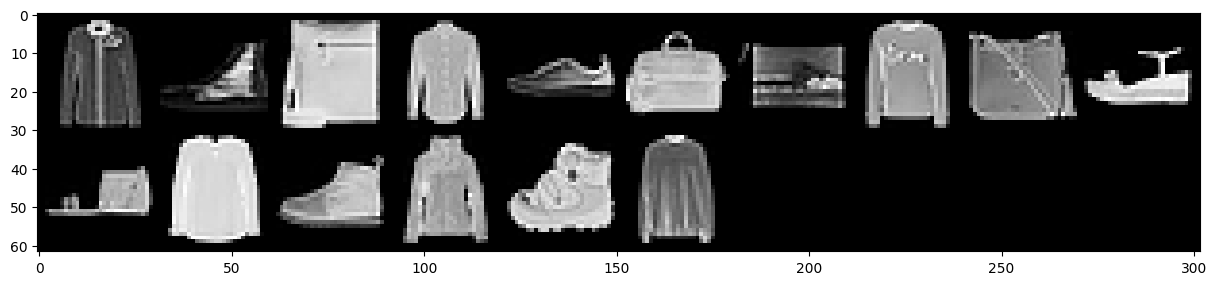

In [8]:
sample_images, sample_labels = next(iter(data_loader_train))
grid = torchvision.utils.make_grid(sample_images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

for _, label in enumerate(sample_labels):
    print(lable_name(label), end = ", ")

In [9]:
class MultilayerNetwork(torch.nn.Module):
    def __init__(self, hidden_layers_sizes: tuple, input_size: int, output_size: int):
        super(MultilayerNetwork, self).__init__()

        self._layers = torch.nn.ModuleList()
        curr_size = input_size
        for hidden_layer_size in hidden_layers_sizes:
            layer = torch.nn.Linear(curr_size, hidden_layer_size)
            torch.nn.init.normal_(layer.weight)
            torch.nn.init.normal_(layer.bias)
            self._layers.append(layer)
            self._layers.append(torch.nn.LeakyReLU())
            curr_size = hidden_layer_size
        output_layer = torch.nn.Linear(curr_size, output_size) 
        torch.nn.init.normal_(output_layer.weight)
        torch.nn.init.normal_(output_layer.bias)
        self._layers.append(output_layer)
        self._layers.append(torch.nn.LogSoftmax(dim=1))

    def forward(self, inputs):
        x = inputs
        for layer in self._layers:
            x = x.view(x.shape[0], -1)
            x = layer(x)
        return x

In [10]:
def train_model(model: torch.nn.Module, train_set: torch.Tensor, test_set: torch.Tensor, batch_size: int, optimizer, loss, max_iter: int, learning_rate: float, output_size: int, verb=False):
    
    optimizer = optimizer(model.parameters(), lr = learning_rate) 

    losses = []
    losses_test = []

    accuracy = []
    precision = []
    f_score = []
    recalls = []

    if batch_size > len(train_set):
        batch_size = len(train_set)

    data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    metric_accuracy = MulticlassAccuracy(num_classes=output_size)
    metric_precision = MulticlassPrecision(num_classes=output_size)
    metric_f_score = MulticlassF1Score(num_classes=output_size)
    metric_recall = MulticlassRecall(num_classes=output_size)

    for index in range(max_iter): #learn for max_iter  
        curr_train_loss = 0   
        curr_test_loss = 0
        metric_accuracy.reset()
        metric_precision.reset()
        metric_f_score.reset()
        metric_recall.reset()
        
        # for each batch perform learning
        for x_train_batch, y_train_batch in data_loader_train:
            optimizer.zero_grad()
            y_pred = model(x_train_batch)
            loss_value = loss(y_pred, y_train_batch)
            loss_value.backward()
            optimizer.step()
            curr_train_loss += loss_value.item()
                
        losses.append(curr_train_loss / len(data_loader_train))

        with torch.no_grad():
            model.eval()
            for x_test_batch, y_test_batch in data_loader_test:
                test_pred = model(x_test_batch)
                loss_test_value = loss(test_pred, y_test_batch)
                curr_test_loss += loss_test_value.item()

                #calculate scores for each batch of iteration
                metric_accuracy.update(test_pred, y_test_batch)
                metric_precision.update(test_pred, y_test_batch)
                metric_f_score.update(test_pred, y_test_batch)
                metric_recall.update(test_pred, y_test_batch)

            losses_test.append(curr_test_loss / len(data_loader_test))    
            accuracy.append(metric_accuracy.compute())
            precision.append(metric_precision.compute())
            f_score.append(metric_f_score.compute())
            recalls.append(metric_recall.compute())

        if verb and index % 10 == 0:
            print("---------------------------------------------- Interation " + str(index))
            print("Train loss on " + str(index) + " iteration: ", losses[index])
            print("Test loss on " + str(index) + " iteration: ", losses_test[index])
            print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
            print("Precision on " + str(index) + " iteration: ", precision[index])
            print("Recall on " + str(index) + " iteration: ", recalls[index])
            print("Fscore on " + str(index) + " iteration: ", f_score[index])
            print("----------------------------------------------\n")

    print("Result of learning process for " + str(max_iter) + " iterations")
    print("--------------------------------------------------------\n")
    print("Train loss: ", losses[-1])
    print("Test loss: ", losses_test[-1])
    print("----------------------------------------------\n")
    print("Scores")
    print("Accuracy: ", accuracy[-1])
    print("Precision: ", precision[-1])
    print("F_score: ", f_score[-1])
    print("Recall: ", recalls[-1])    
    return losses, losses_test, accuracy, f_score, recalls

In [11]:
def plot_learning(losses: list, losses_test: list, title: str, axs = None):
    if axs == None:
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        axs.plot(np.arange(len(losses)), losses, label="Train Loss")
        axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
        axs.set_title(title)
        axs.legend()

<h1>Eksperymenty</h1>

In [12]:
optimizer = torch.optim.Adam
loss = torch.nn.CrossEntropyLoss()
max_iter = 100
verbose = False
train_set_6 = get_subset(train_set, 6)
test_set_6 = get_subset(test_set, 6)
learning_rate = 0.001

#1 Liczba neuronów w warstwie ukrytej
hiddenLayer_20 = (20,)
hiddenLayer_50 = (50,)

# Dwuwarstwowa sieć
hiddenLayer_20_10 = (20, 10)
hiddenLayer_50_30 = (50, 30)

#2 Rozmiar batch'a
batch_size_1 = 16
batch_size_2 = 100
batch_size_3 = 1000

#3 Liczba przykładów uczących
train_set_1 = get_subset(train_set, 1)
test_set_1 = get_subset(test_set, 1)
train_set_10 = get_subset(train_set, 10)
test_set_10 = get_subset(test_set, 10)

#4 Zaburzenie danych
train_set_gauss = torchvision.datasets.FashionMNIST('path', download = True, train = True, transform = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(7, 7))]))
test_set_gauss = torchvision.datasets.FashionMNIST('path', download = True, train = False, transform = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(7, 7))]))

train_set_gauss_6 = get_subset(train_set_gauss, 6)
test_set_gauss_6 = get_subset(test_set_gauss, 6)


In [13]:
plt.style.use('seaborn-v0_8-muted')

# options [0] -> hidden_layers, [1] -> train_set, [2] -> test_set, [3] -> output_size, [4] -> batch_size
def run_models(options, options_title):
    fig, axs = plt.subplots(1, len(options), figsize=(20, 5))
    for option_index, option in enumerate(options):
        input_size = option[1][0][0].shape[1] * option[1][0][0].shape[2] # width times height of image
        model = MultilayerNetwork(option[0], input_size, option[3])
        result = train_model(model, option[1], option[2], option[4], optimizer, loss, max_iter, learning_rate, option[3], verb=verbose)
        plot_learning(result[0], result[1], options_title[option_index], axs[option_index])


<h1>Jednowarstwowa sieć</h1>

<h2>#1 Liczba neuronów w warstwie ukrytej</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.2298091152517332
Test loss:  0.8864387023311696
----------------------------------------------

Scores
Accuracy:  tensor(0.8227)
Precision:  tensor(0.8256)
F_score:  tensor(0.8226)
Recall:  tensor(0.8227)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.0553183569231381
Test loss:  1.7089511952362955
----------------------------------------------

Scores
Accuracy:  tensor(0.8071)
Precision:  tensor(0.8180)
F_score:  tensor(0.8093)
Recall:  tensor(0.8071)


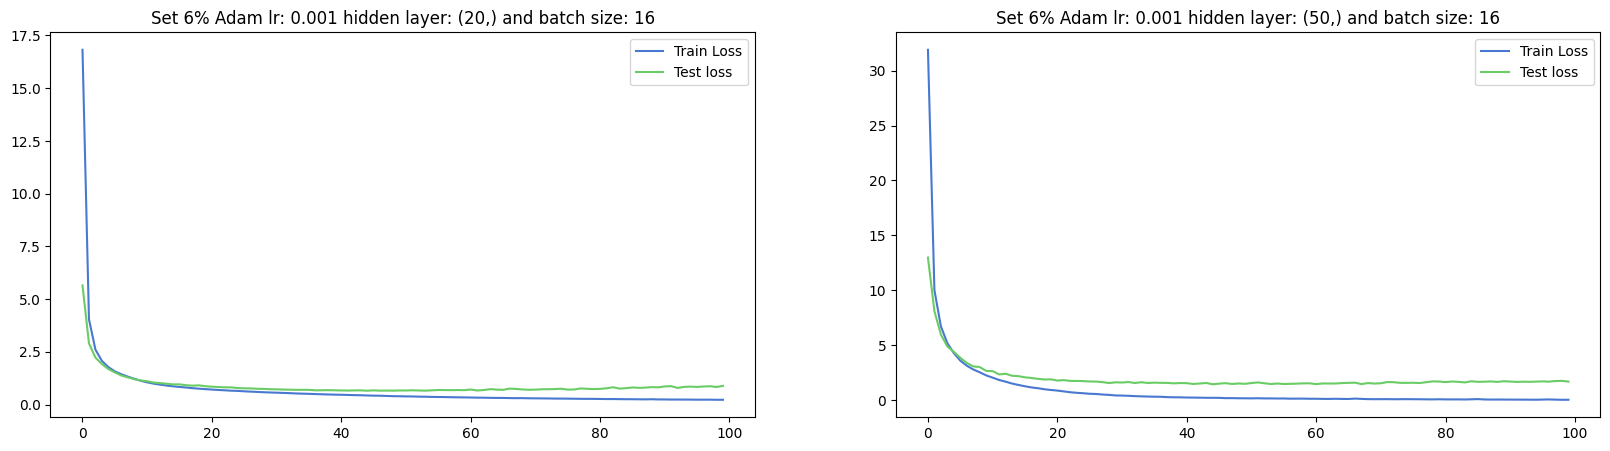

In [14]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_50, train_set_6, test_set_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_50) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#2 Rozmiar batch'a</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.2444738514555825
Test loss:  0.7890803094365095
----------------------------------------------

Scores
Accuracy:  tensor(0.8026)
Precision:  tensor(0.8090)
F_score:  tensor(0.8036)
Recall:  tensor(0.8026)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.5253431283765368
Test loss:  1.00223974386851
----------------------------------------------

Scores
Accuracy:  tensor(0.7417)
Precision:  tensor(0.7447)
F_score:  tensor(0.7401)
Recall:  tensor(0.7417)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  2.220684766769409
Test loss:  2.3761229515075684
----------------------------------------------

Scores
Accuracy:  tensor(0.5098)
Precision:  tensor(0.5381)
F_score:  tensor(0.5132)
Recall:  tensor(0.5098)


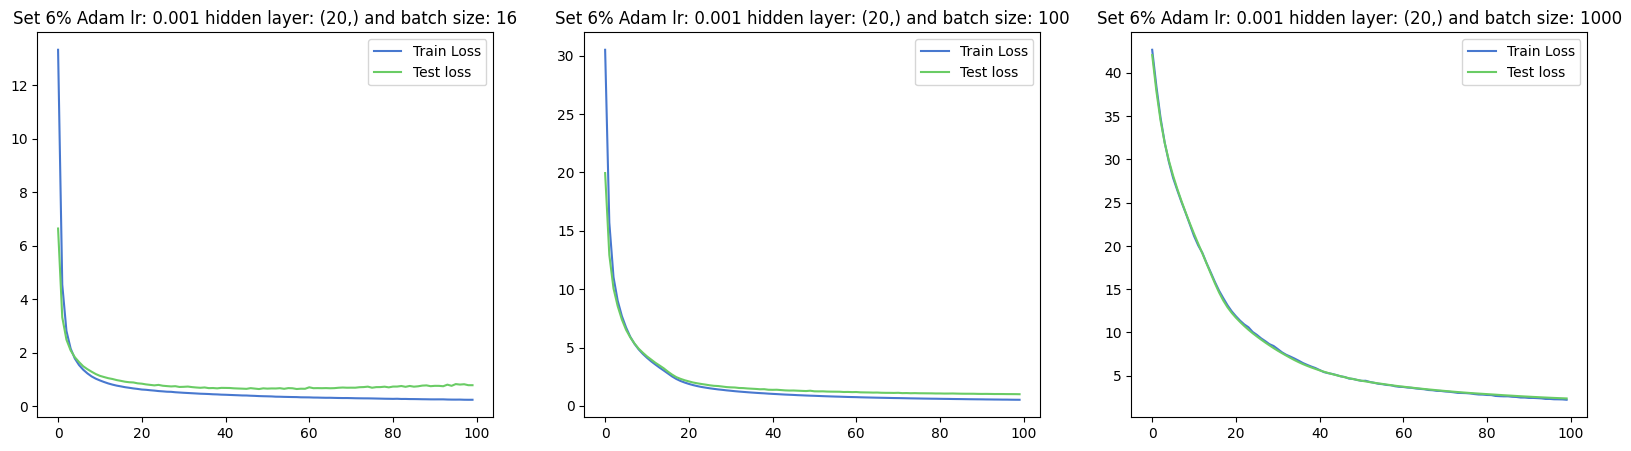

In [15]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_2],
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_3]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_2),
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_3)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#3 Liczba przykładów uczących</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.46157856952202947
Test loss:  4.034822872706822
----------------------------------------------

Scores
Accuracy:  tensor(0.5946)
Precision:  tensor(0.5823)
F_score:  tensor(0.5609)
Recall:  tensor(0.5946)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.2223274598456919
Test loss:  1.003962886568747
----------------------------------------------

Scores
Accuracy:  tensor(0.8097)
Precision:  tensor(0.8122)
F_score:  tensor(0.8094)
Recall:  tensor(0.8097)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.2403790268537899
Test loss:  1.0377060230230055
----------------------------------------------

Scores
Accuracy:  tensor(0.8172)
Precision:  tensor(0.8216)
F_score:  tensor(0.8187)
Recall:  tensor(0.8172)


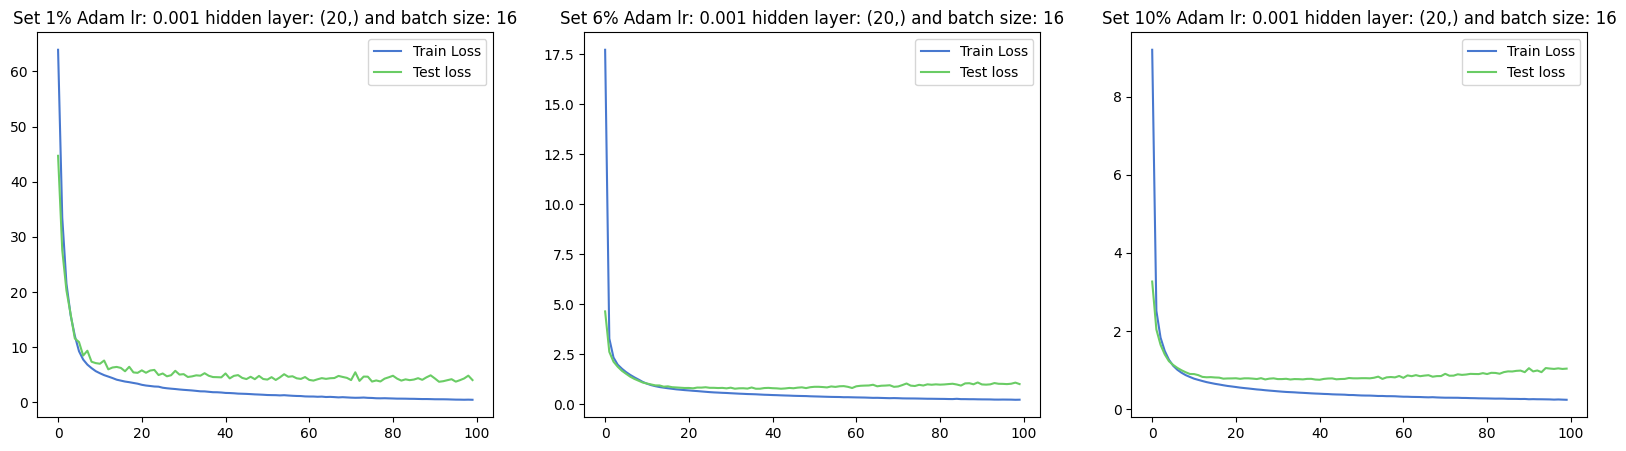

In [16]:
options_neurons_size = [[hiddenLayer_20, train_set_1, test_set_1, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1],
                        [hiddenLayer_20, train_set_10, test_set_10, 10, batch_size_1]]

options_neurons_titles = ["Set 1% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1),
                          "Set 10% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#4 Zaburzenie danych</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.2267249482538965
Test loss:  1.0059491392028959
----------------------------------------------

Scores
Accuracy:  tensor(0.8210)
Precision:  tensor(0.8220)
F_score:  tensor(0.8205)
Recall:  tensor(0.8210)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.23806773232916992
Test loss:  0.8767802597660768
----------------------------------------------

Scores
Accuracy:  tensor(0.7794)
Precision:  tensor(0.7930)
F_score:  tensor(0.7759)
Recall:  tensor(0.7794)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3988907514512539
Test loss:  0.6223234334274342
----------------------------------------------

Scores
Accuracy:  tensor(0.8174)
Precision:  tensor(0.8124)
F_score:  tensor(0.8131)
Recall:  tensor(0.8174)


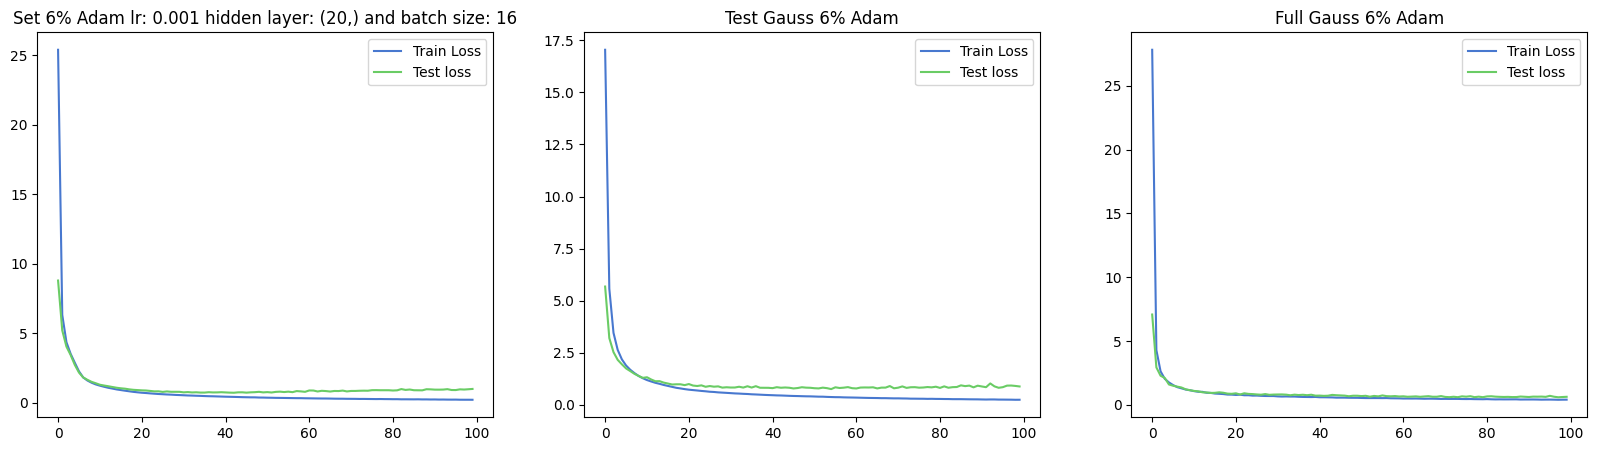

In [17]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_gauss_6, 10, batch_size_1],
                        [hiddenLayer_20, train_set_gauss_6, test_set_gauss_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Test Gauss 6% Adam",
                          "Full Gauss 6% Adam"]

run_models(options_neurons_size, options_neurons_titles)

<h1>Dwuwartwowa sieć</h1>

<h2>#1 Liczba neuronów w warstwie ukrytej</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3325123990329707
Test loss:  0.6602535806596279
----------------------------------------------

Scores
Accuracy:  tensor(0.8119)
Precision:  tensor(0.8168)
F_score:  tensor(0.8125)
Recall:  tensor(0.8119)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.19206729545051024
Test loss:  1.734733417140026
----------------------------------------------

Scores
Accuracy:  tensor(0.8049)
Precision:  tensor(0.8033)
F_score:  tensor(0.8031)
Recall:  tensor(0.8049)


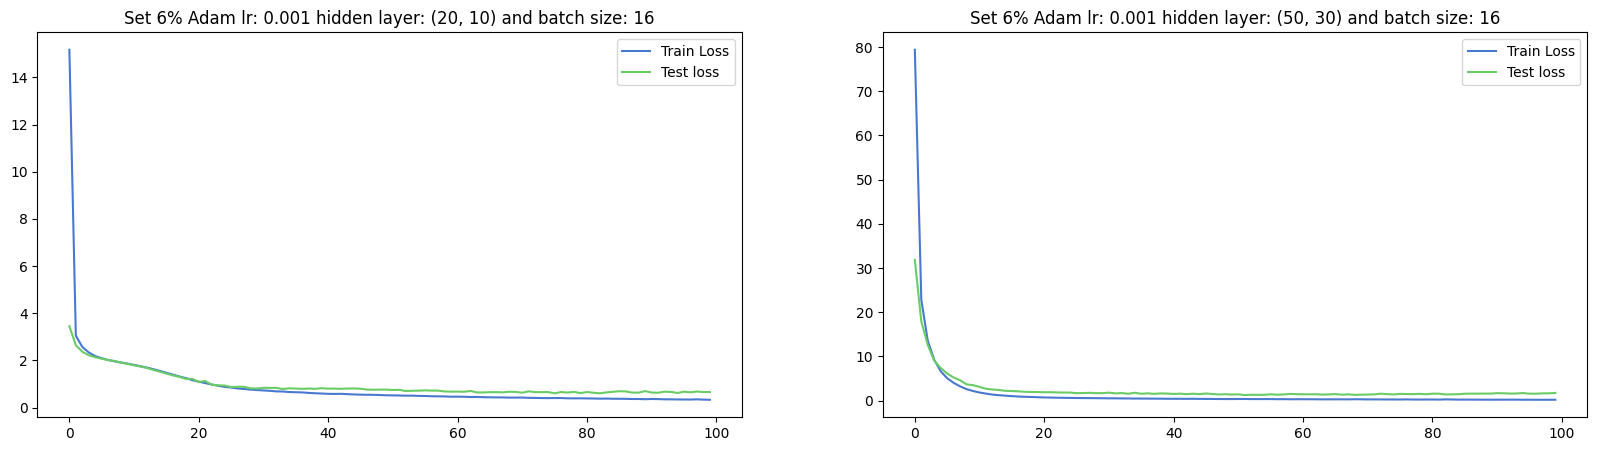

In [18]:
options_neurons_size = [[hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_50_30, train_set_6, test_set_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_50_30) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#2 Rozmiar batch'a</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.3316931525866191
Test loss:  0.7771174048906878
----------------------------------------------

Scores
Accuracy:  tensor(0.8101)
Precision:  tensor(0.8159)
F_score:  tensor(0.8113)
Recall:  tensor(0.8101)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.69543733033869
Test loss:  0.8209558228651682
----------------------------------------------

Scores
Accuracy:  tensor(0.7074)
Precision:  tensor(0.7124)
F_score:  tensor(0.7042)
Recall:  tensor(0.7074)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  2.5670897364616394
Test loss:  2.4829044342041016
----------------------------------------------

Scores
Accuracy:  tensor(0.3239)
Precision:  tensor(0.3260)
F_score:  tensor(0.3027)
Recall:  tensor(0.3239)


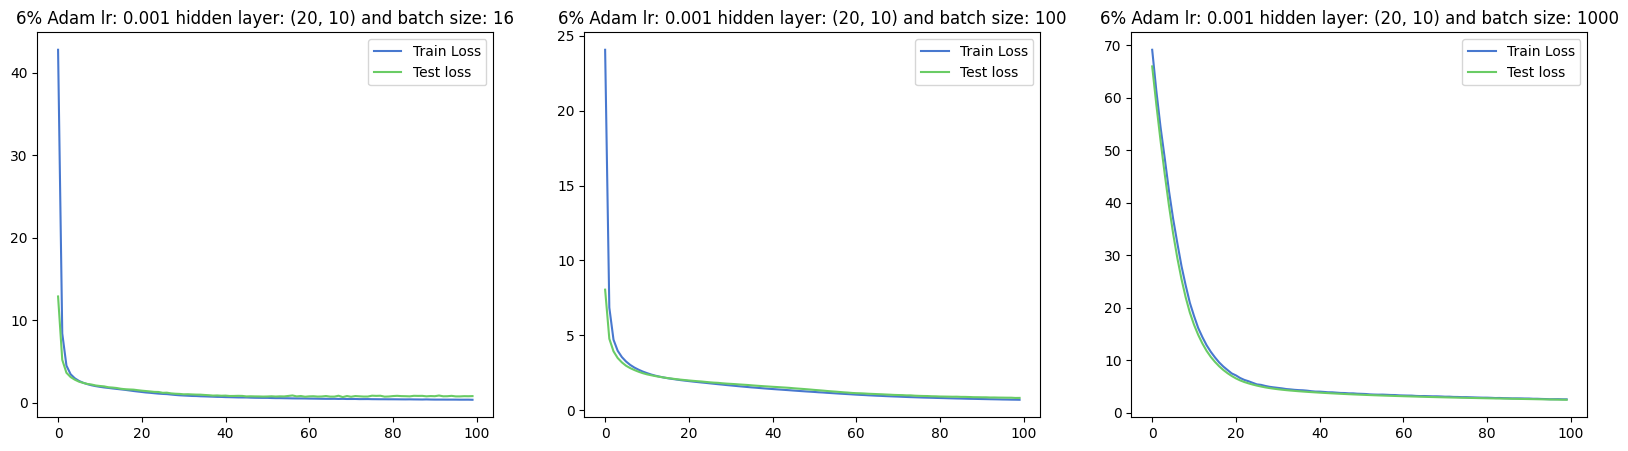

In [19]:
options_neurons_size = [[hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_2],
                        [hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_3]]

options_neurons_titles = ["6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_2),
                          "6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_3)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#3 Liczba przykładów uczących</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.8609409944007271
Test loss:  1.7994923080716814
----------------------------------------------

Scores
Accuracy:  tensor(0.6164)
Precision:  tensor(0.5956)
F_score:  tensor(0.5691)
Recall:  tensor(0.6164)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.2828761208636893
Test loss:  0.7011441627615377
----------------------------------------------

Scores
Accuracy:  tensor(0.8117)
Precision:  tensor(0.8214)
F_score:  tensor(0.8146)
Recall:  tensor(0.8117)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.26516395748655003
Test loss:  0.7942128467654425
----------------------------------------------

Scores
Accuracy:  tensor(0.8128)
Precision:  tensor(0.8172)
F_score:  tensor(0.8140)
Recall:  tensor(0.8128)


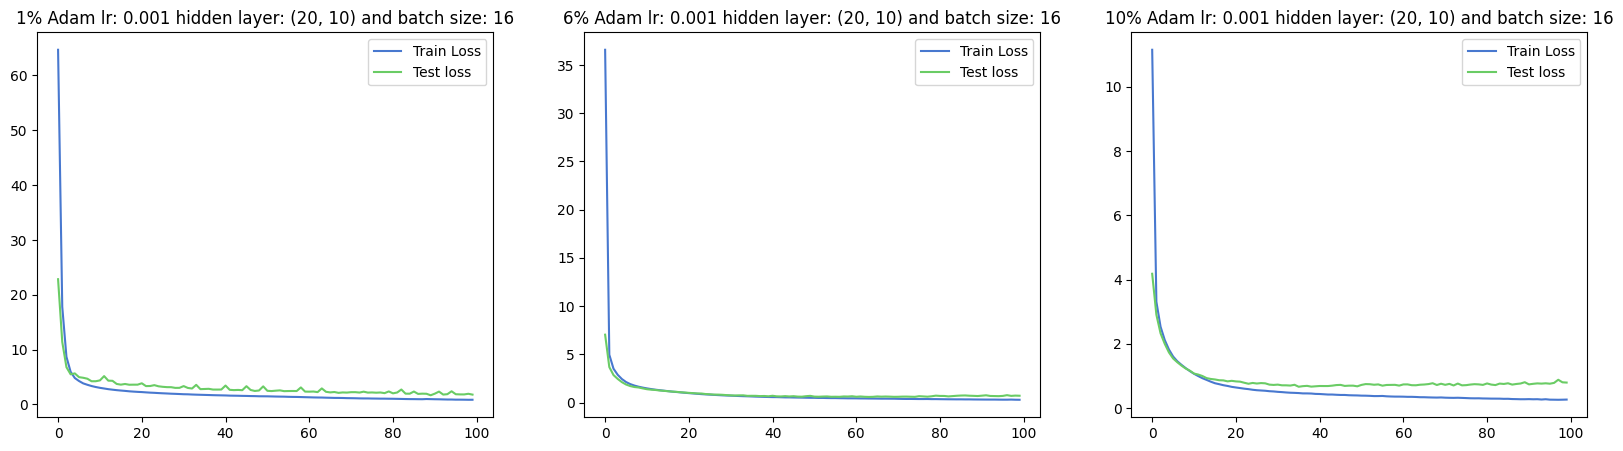

In [22]:
options_neurons_size = [[hiddenLayer_20_10, train_set_1, test_set_1, 10, batch_size_1], 
                        [hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1],
                        [hiddenLayer_20_10, train_set_10, test_set_10, 10, batch_size_1]]

options_neurons_titles = ["1% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1),
                          "10% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#4 Zaburzenie danych</h2>

Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.2940491968062189
Test loss:  0.7855334687781962
----------------------------------------------

Scores
Accuracy:  tensor(0.8232)
Precision:  tensor(0.8230)
F_score:  tensor(0.8217)
Recall:  tensor(0.8232)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.34034945864644317
Test loss:  0.9098769669470034
----------------------------------------------

Scores
Accuracy:  tensor(0.7567)
Precision:  tensor(0.7603)
F_score:  tensor(0.7448)
Recall:  tensor(0.7567)
Result of learning process for 100 iterations
--------------------------------------------------------

Train loss:  0.5000763173235787
Test loss:  0.8112898602297431
----------------------------------------------

Scores
Accuracy:  tensor(0.7794)
Precision:  tensor(0.7752)
F_score:  tensor(0.7725)
Recall:  tensor(0.7794)


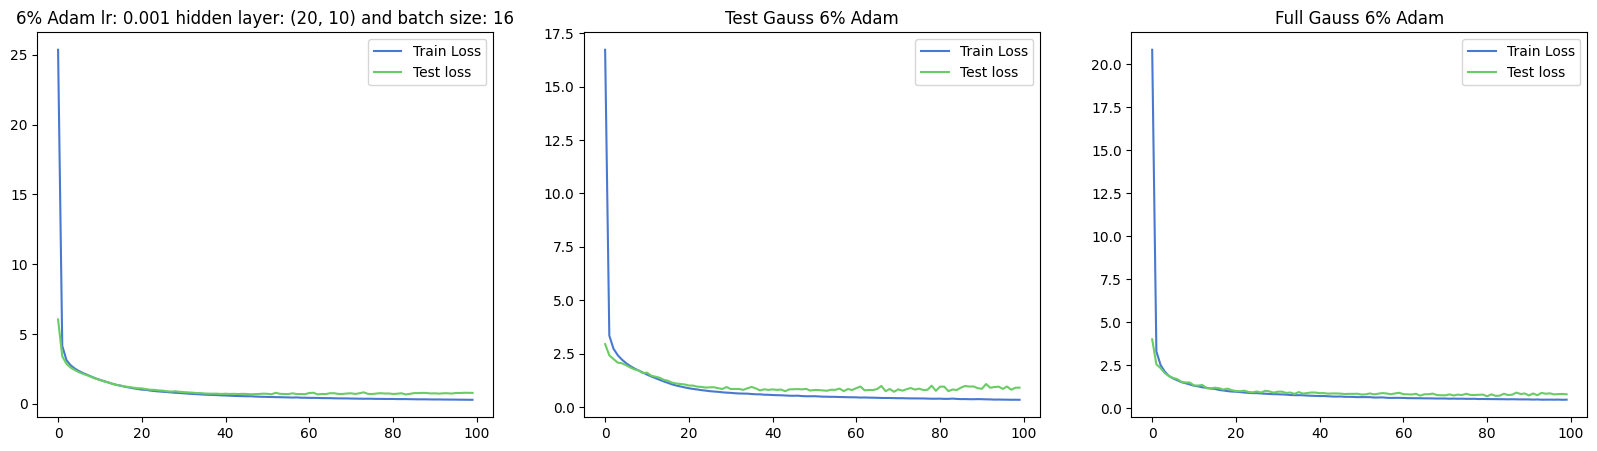

In [21]:
options_neurons_size = [[hiddenLayer_20_10, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20_10, train_set_6, test_set_gauss_6, 10, batch_size_1],
                        [hiddenLayer_20_10, train_set_gauss_6, test_set_gauss_6, 10, batch_size_1]]

options_neurons_titles = ["6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20_10) + " and batch size: " + str(batch_size_1), 
                          "Test Gauss 6% Adam",
                          "Full Gauss 6% Adam"]

run_models(options_neurons_size, options_neurons_titles)

<p><i>Wykonane przez Szymona Sawczuka nr indeksu 260287</i></p>